In [12]:
# LangGraph Prompt Optimization System
# This notebook creates a 4-agent system for prompt optimization using LangGraph

# Installation and Setup
%pip install --upgrade --quiet langgraph langchain-google-vertexai google-cloud-aiplatform[evaluation] pandas

import os
import sys
import json
import pandas as pd
from typing import Dict, List, Any, TypedDict, Annotated
from IPython.display import display, Markdown

# Google Cloud Setup
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

PROJECT_IDS = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_IDS[0]

if not PROJECT_ID:
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = "us-central1"
EXPERIMENT_NAME = "prompt-optimization-experiment"

os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_LOCATION"] = LOCATION
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "TRUE"

print(f"Project ID: {PROJECT_ID}")
print(f"Location: {LOCATION}")

# LangGraph and LangChain imports
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_google_vertexai import ChatVertexAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
import vertexai
from vertexai.evaluation import EvalTask, PointwiseMetric, PointwiseMetricPromptTemplate

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Initialize the LLM
llm = ChatVertexAI(
    model_name="gemini-2.0-flash-001",
    temperature=0.7,
    max_tokens=2048
)

print("✅ Setup completed successfully!")


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Project ID: my-project-0004-346516
Location: us-central1
✅ Setup completed successfully!


### Agent logic

In [23]:

# =============================================================================
# STATE DEFINITION
# =============================================================================

# Define the state that will be passed between agents
class PromptOptimizationState(TypedDict):
    original_prompt: str
    current_prompt: str
    test_dataset: List[Dict[str, str]]
    agent2_results: List[Dict[str, Any]]
    evaluation_results: Dict[str, Any]
    enhancement_recommendations: str
    enhancement_makes_sense: bool
    final_prompt: str
    iteration: int
    max_iterations: int
    iteration_history: List[Dict[str, Any]]  # Track all iterations
    should_continue_optimizing: bool

print("✅ State definition completed!")

# =============================================================================
# AGENT 1: DATASET GENERATOR
# =============================================================================

def agent1_dataset_generator(state: PromptOptimizationState) -> PromptOptimizationState:
    """
    Agent 1: Generates a dataset of input-output pairs for testing the prompt
    Creates challenging test cases to ensure original prompt doesn't get 100% success rate
    """
    print("🤖 Agent 1: Generating test dataset...")
    
    original_prompt = state["original_prompt"]
    
    # First, create an initial dataset
    dataset_generation_prompt = f"""
    You are a dataset generation expert. Given the following prompt, generate 6 diverse input-output pairs that would be good for testing this prompt.
    
    Original Prompt: {original_prompt}
    
    Generate 6 test cases with varied inputs that would help evaluate how well this prompt performs. 
    Each test case should have:
    - input: A realistic input scenario
    - expected_output: What a good response should look like
    
    Make the test cases diverse to cover different scenarios and complexity levels.
    
    Return ONLY a valid JSON array in this format:
    [
        {{"input": "test input 1", "expected_output": "expected response 1"}},
        {{"input": "test input 2", "expected_output": "expected response 2"}},
        ...
    ]
    """
    
    try:
        response = llm.invoke([HumanMessage(content=dataset_generation_prompt)])
        
        # Extract JSON from response
        response_text = response.content.strip()
        if response_text.startswith("```json"):
            response_text = response_text[7:-3].strip()
        elif response_text.startswith("```"):
            response_text = response_text[3:-3].strip()
        
        initial_dataset = json.loads(response_text)
        print(f"✅ Generated initial {len(initial_dataset)} test cases")
        
        # Test the original prompt on initial dataset
        print("🧪 Testing original prompt on initial dataset...")
        test_results = []
        success_count = 0
        
        for i, test_case in enumerate(initial_dataset):
            full_prompt = f"{original_prompt}\n\nInput: {test_case['input']}"
            
            try:
                test_response = llm.invoke([HumanMessage(content=full_prompt)])
                actual_output = test_response.content.strip()
                
                # Simple success check - if output is not empty and doesn't contain obvious errors
                is_success = (len(actual_output) > 10 and 
                             "ERROR" not in actual_output.upper() and
                             "I cannot" not in actual_output and
                             "I don't know" not in actual_output)
                
                if is_success:
                    success_count += 1
                
                test_results.append({
                    "input": test_case["input"],
                    "expected": test_case["expected_output"],
                    "actual": actual_output,
                    "success": is_success
                })
                
            except Exception as e:
                test_results.append({
                    "input": test_case["input"],
                    "expected": test_case["expected_output"],
                    "actual": f"ERROR: {e}",
                    "success": False
                })
        
        initial_success_rate = (success_count / len(initial_dataset)) * 100 if initial_dataset else 0
        print(f"📊 Initial prompt success rate: {initial_success_rate:.1f}% ({success_count}/{len(initial_dataset)})")
        
        # If success rate is too high (>85%), generate more challenging cases
        final_dataset = initial_dataset.copy()
        
        if initial_success_rate > 85:
            print("⚡ Success rate too high - generating challenging test cases...")
            
            challenging_prompt = f"""
            The original prompt achieved {initial_success_rate:.1f}% success rate, which is too high for proper testing.
            
            Original Prompt: {original_prompt}
            
            Current test results:
            {json.dumps(test_results[:3], indent=2)}
            
            Generate 6 MORE CHALLENGING test cases that will likely expose weaknesses in the original prompt.
            These should be:
            1. Edge cases or unusual inputs
            2. Complex scenarios requiring nuanced responses
            3. Ambiguous inputs that could be interpreted multiple ways
            4. Cases that test the limits of the prompt's specificity
            5. Scenarios with missing or incomplete information
            6. Cases that require domain-specific knowledge or reasoning
            
            Make these significantly more difficult than the initial cases to bring the overall success rate down to 70-80%.
            
            Return ONLY a valid JSON array with 6 challenging test cases:
            [
                {{"input": "challenging input 1", "expected_output": "expected response 1"}},
                {{"input": "challenging input 2", "expected_output": "expected response 2"}},
                ...
            ]
            """
            
            try:
                challenging_response = llm.invoke([HumanMessage(content=challenging_prompt)])
                challenging_text = challenging_response.content.strip()
                
                if challenging_text.startswith("```json"):
                    challenging_text = challenging_text[7:-3].strip()
                elif challenging_text.startswith("```"):
                    challenging_text = challenging_text[3:-3].strip()
                
                challenging_dataset = json.loads(challenging_text)
                print(f"✅ Generated {len(challenging_dataset)} challenging test cases")
                
                # Combine datasets
                final_dataset.extend(challenging_dataset)
                
                # Test combined dataset
                print("🧪 Testing original prompt on combined dataset...")
                combined_success = 0
                
                for test_case in challenging_dataset:
                    full_prompt = f"{original_prompt}\n\nInput: {test_case['input']}"
                    
                    try:
                        test_response = llm.invoke([HumanMessage(content=full_prompt)])
                        actual_output = test_response.content.strip()
                        
                        is_success = (len(actual_output) > 10 and 
                                     "ERROR" not in actual_output.upper() and
                                     "I cannot" not in actual_output and
                                     "I don't know" not in actual_output)
                        
                        if is_success:
                            combined_success += 1
                            
                    except:
                        pass
                
                total_success = success_count + combined_success
                combined_success_rate = (total_success / len(final_dataset)) * 100
                print(f"📊 Combined dataset success rate: {combined_success_rate:.1f}% ({total_success}/{len(final_dataset)})")
                
            except Exception as e:
                print(f"⚠️ Error generating challenging cases: {e}")
                # If challenging generation fails, manually add some generic challenging cases
                generic_challenging = [
                    {"input": "Handle this ambiguous request with missing context", "expected_output": "Should ask for clarification while providing helpful guidance"},
                    {"input": "Process this edge case scenario that wasn't covered in training", "expected_output": "Should gracefully handle unknown scenarios"},
                    {"input": "Deal with conflicting requirements in this complex situation", "expected_output": "Should prioritize and explain trade-offs"},
                    {"input": "Respond to this intentionally vague and incomplete query", "expected_output": "Should seek clarification while offering relevant suggestions"},
                    {"input": "Handle this unusual format that doesn't match expected patterns", "expected_output": "Should adapt to unusual formats while maintaining quality"},
                    {"input": "Process this request that requires domain expertise you might lack", "expected_output": "Should acknowledge limitations while providing best effort response"}
                ]
                final_dataset.extend(generic_challenging)
                print(f"✅ Added {len(generic_challenging)} generic challenging cases")
        
        # Validate final dataset structure
        if not isinstance(final_dataset, list):
            raise ValueError("Dataset should be a list")
        
        # Clean and validate each item in the dataset
        validated_dataset = []
        for i, item in enumerate(final_dataset):
            if isinstance(item, dict):
                # Ensure required keys exist, create them if missing
                if "input" not in item:
                    item["input"] = f"Test input {i+1}"
                if "expected_output" not in item:
                    item["expected_output"] = f"Expected output {i+1}"
                
                # Clean the item to only have required keys
                clean_item = {
                    "input": str(item["input"]),
                    "expected_output": str(item["expected_output"])
                }
                validated_dataset.append(clean_item)
            else:
                # If item is not a dict, create a default one
                validated_dataset.append({
                    "input": f"Test input {i+1}",
                    "expected_output": f"Expected output {i+1}"
                })
        
        final_dataset = validated_dataset
        
        state["test_dataset"] = final_dataset
        print(f"✅ Final dataset ready with {len(final_dataset)} test cases")
        
        # Save dataset to file
        import os
        import datetime
        
        # Create datasets folder if it doesn't exist
        os.makedirs("datasets", exist_ok=True)
        
        # Generate filename with timestamp to avoid overwriting
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"datasets/test_dataset_{timestamp}.json"
        
        # Check if file exists and create versioned filename
        counter = 1
        original_filename = filename
        while os.path.exists(filename):
            base_name = original_filename.replace(".json", "")
            filename = f"{base_name}_v{counter}.json"
            counter += 1
        
        # Save the dataset with metadata
        dataset_with_metadata = {
            "metadata": {
                "original_prompt": original_prompt,
                "total_cases": len(final_dataset),
                "initial_success_rate": initial_success_rate,
                "generation_timestamp": timestamp
            },
            "test_cases": final_dataset
        }
        
        with open(filename, "w") as f:
            json.dump(dataset_with_metadata, f, indent=2)
        
        print(f"💾 Dataset saved to: {filename}")
        
        # Display sample test cases
        print("\n📋 Sample test cases:")
        for i, case in enumerate(final_dataset[:3]):
            print(f"Case {i+1}:")
            input_text = case['input'] if len(case['input']) <= 100 else case['input'][:100] + "..."
            expected_text = case['expected_output'] if len(case['expected_output']) <= 100 else case['expected_output'][:100] + "..."
            print(f"  Input: {input_text}")
            print(f"  Expected: {expected_text}")
            print()
        
    except Exception as e:
        print(f"❌ Error generating dataset: {e}")
        # Fallback: create a challenging dataset
        state["test_dataset"] = [
            {"input": "Handle this complex multi-part request with unclear requirements", "expected_output": "Should break down the request and ask for clarification"},
            {"input": "Process this edge case that wasn't covered in the original prompt", "expected_output": "Should adapt and provide best effort response"},
            {"input": "Deal with conflicting instructions in this scenario", "expected_output": "Should identify conflicts and prioritize appropriately"},
            {"input": "Respond to this ambiguous query with missing context", "expected_output": "Should seek clarification while providing helpful guidance"},
            {"input": "Handle this unusual format input", "expected_output": "Should adapt to format while maintaining response quality"},
            {"input": "Process this request requiring specialized knowledge", "expected_output": "Should acknowledge limitations and provide general guidance"},
            {"input": "Basic straightforward request", "expected_output": "Should handle this easily with clear response"},
            {"input": "Another standard case", "expected_output": "Should respond appropriately"},
            {"input": "Simple test case", "expected_output": "Should work well"},
            {"input": "Regular scenario", "expected_output": "Should handle normally"},
            {"input": "Standard input", "expected_output": "Should process correctly"},
            {"input": "Normal case", "expected_output": "Should respond properly"}
        ]
        print(f"✅ Using fallback dataset with {len(state['test_dataset'])} cases")
    
    return state

# =============================================================================
# AGENT 2: PROMPT EXECUTOR
# =============================================================================

def agent2_prompt_executor(state: PromptOptimizationState) -> PromptOptimizationState:
    """
    Agent 2: Executes the current prompt against all test cases and collects results
    """
    print("🤖 Agent 2: Executing prompt against test dataset...")
    
    current_prompt = state["current_prompt"]
    test_dataset = state["test_dataset"]
    results = []
    
    for i, test_case in enumerate(test_dataset):
        print(f"Processing test case {i+1}/12...", end=" ")
        
        # Apply the current prompt to the test input
        full_prompt = f"{current_prompt}\n\nInput: {test_case['input']}"
        
        try:
            response = llm.invoke([HumanMessage(content=full_prompt)])
            actual_output = response.content.strip()
            
            result = {
                "test_case_id": i + 1,
                "input": test_case["input"],
                "expected_output": test_case["expected_output"],
                "actual_output": actual_output,
                "prompt_used": current_prompt
            }
            results.append(result)
            print("✅")
            
        except Exception as e:
            print(f"❌ Error: {e}")
            result = {
                "test_case_id": i + 1,
                "input": test_case["input"],
                "expected_output": test_case["expected_output"],
                "actual_output": f"ERROR: {str(e)}",
                "prompt_used": current_prompt
            }
            results.append(result)
    
    state["agent2_results"] = results
    print(f"✅ Completed execution on {len(results)} test cases")
    
    return state

# =============================================================================
# AGENT 3: EVALUATION ANALYZER
# =============================================================================

def agent3_evaluation_analyzer(state: PromptOptimizationState) -> PromptOptimizationState:
    """
    Agent 3: Analyzes the results using Vertex AI evaluation and provides enhancement recommendations
    """
    print("🤖 Agent 3: Analyzing results and generating recommendations...")
    
    results = state["agent2_results"]
    
    # Create evaluation dataset
    eval_data = []
    for result in results:
        eval_data.append({
            "input": result["input"],
            "expected_output": result["expected_output"],
            "response": result["actual_output"]  # Changed from actual_output to response
        })
    
    eval_df = pd.DataFrame(eval_data)
    
    # Define custom evaluation metric for prompt quality
    prompt_quality_metric = PointwiseMetric(
        metric="prompt_quality",
        metric_prompt_template=PointwiseMetricPromptTemplate(
            criteria={
                "accuracy": "The actual output matches the expected output in terms of correctness and completeness",
                "relevance": "The actual output is relevant to the input and addresses the main points",
                "clarity": "The actual output is clear, well-structured, and easy to understand",
                "consistency": "The output style and format are consistent with expectations"
            },
            rating_rubric={
                "5": "Excellent: Meets all criteria exceptionally well",
                "4": "Good: Meets most criteria well with minor issues",
                "3": "Average: Meets some criteria but has notable gaps",
                "2": "Poor: Falls short on most criteria",
                "1": "Very Poor: Fails to meet criteria"
            },
        ),
    )
    
    try:
        # Run evaluation
        eval_task = EvalTask(
            dataset=eval_df,
            metrics=[prompt_quality_metric],
            experiment=EXPERIMENT_NAME
        )
        
        eval_result = eval_task.evaluate()
        
        # Extract evaluation scores
        scores = []
        if hasattr(eval_result, 'summary_metrics'):
            for metric_name, metric_value in eval_result.summary_metrics.items():
                scores.append(f"{metric_name}: {metric_value}")
        
        evaluation_summary = "\n".join(scores) if scores else "Evaluation completed"
        
        # Calculate simple metrics as fallback
        total_cases = len(results)
        success_cases = sum(1 for r in results if "ERROR" not in r["actual_output"])
        success_rate = (success_cases / total_cases) * 100 if total_cases > 0 else 0
        
        evaluation_summary += f"\nSuccess Rate: {success_rate:.1f}% ({success_cases}/{total_cases})"
        
    except Exception as e:
        print(f"⚠️ Evaluation error: {e}")
        # Fallback evaluation
        total_cases = len(results)
        success_cases = sum(1 for r in results if "ERROR" not in r["actual_output"])
        success_rate = (success_cases / total_cases) * 100 if total_cases > 0 else 0
        evaluation_summary = f"Basic Evaluation - Success Rate: {success_rate:.1f}% ({success_cases}/{total_cases})"
    
    # Generate enhancement recommendations using LLM
    analysis_prompt = f"""
    You are a prompt engineering expert. Analyze the following test results and provide specific recommendations to improve the prompt.
    
    Original Prompt: {state["current_prompt"]}
    
    Evaluation Summary: {evaluation_summary}
    
    Sample Results:
    {json.dumps(results[:3], indent=2)}
    
    Based on this analysis, provide specific, actionable recommendations to enhance the prompt. 
    Focus on:
    1. What patterns of errors or suboptimal responses do you see?
    2. How can the prompt be made clearer or more specific?
    3. What instructions or examples should be added?
    4. What formatting or structure improvements are needed?
    
    Provide your recommendations in a clear, structured format.
    """
    
    try:
        analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
        enhancement_recommendations = analysis_response.content.strip()
    except Exception as e:
        enhancement_recommendations = f"Error generating recommendations: {e}"
    
    state["evaluation_results"] = {
        "summary": evaluation_summary,
        "total_cases": len(results),
        "success_cases": sum(1 for r in results if "ERROR" not in r["actual_output"]),
        "detailed_results": results,
        "success_rate": success_rate
    }
    state["enhancement_recommendations"] = enhancement_recommendations
    
    # Store iteration history
    if "iteration_history" not in state:
        state["iteration_history"] = []
    
    iteration_data = {
        "iteration": state.get("iteration", 1),
        "prompt": state["current_prompt"],
        "success_rate": success_rate,
        "evaluation_summary": evaluation_summary,
        "recommendations": enhancement_recommendations
    }
    state["iteration_history"].append(iteration_data)
    
    print("✅ Evaluation completed")
    print(f"📊 {evaluation_summary}")
    print(f"📝 Recommendations generated")
    
    return state

# =============================================================================
# AGENT 4: ENHANCEMENT VALIDATOR
# =============================================================================

def agent4_enhancement_validator(state: PromptOptimizationState) -> PromptOptimizationState:
    """
    Agent 4: Validates if enhancement recommendations make sense and creates final prompt
    """
    print("🤖 Agent 4: Validating enhancements and finalizing prompt...")
    
    current_prompt = state["current_prompt"]
    recommendations = state["enhancement_recommendations"]
    evaluation_results = state["evaluation_results"]
    iteration = state.get("iteration", 1)
    max_iterations = state.get("max_iterations", 5)  # Increased to 5
    iteration_history = state.get("iteration_history", [])
    
    # Force continuation if we haven't reached minimum iterations (at least 3)
    min_iterations = 3
    current_success_rate = evaluation_results.get("success_rate", 0)
    
    print(f"📊 Current iteration: {iteration}/{max_iterations}")
    print(f"📈 Current success rate: {current_success_rate:.1f}%")
    
    # Enhanced validation logic
    should_continue = False
    
    if iteration < min_iterations:
        # Always continue for first 3 iterations
        should_continue = True
        reasoning = f"Continuing optimization - minimum {min_iterations} iterations required (currently at {iteration})"
    elif iteration < max_iterations:
        # Continue if success rate can be improved or if we have room for improvement
        if current_success_rate < 90:  # Continue if less than 90% success
            should_continue = True
            reasoning = f"Continuing optimization - success rate ({current_success_rate:.1f}%) has room for improvement"
        elif len(iteration_history) >= 2:
            # Check if we're improving compared to previous iteration
            prev_success_rate = iteration_history[-2].get("success_rate", 0)
            if current_success_rate <= prev_success_rate + 5:  # Less than 5% improvement
                should_continue = True
                reasoning = f"Continuing optimization - exploring different approaches for better results"
            else:
                should_continue = False
                reasoning = f"Good improvement achieved - ready to finalize"
        else:
            should_continue = True
            reasoning = "Continuing optimization - need more data points for comparison"
    else:
        should_continue = False
        reasoning = f"Reached maximum iterations ({max_iterations}) - time to select best prompt"
    
    if should_continue:
        # Generate enhanced prompt
        enhancement_prompt = f"""
        You are a prompt engineering expert. Create an improved version of the current prompt based on the analysis.
        
        Current Prompt: {current_prompt}
        
        Current Performance: {current_success_rate:.1f}% success rate
        
        Enhancement Recommendations: {recommendations}
        
        Iteration History:
        {json.dumps(iteration_history, indent=2)}
        
        Create a significantly improved version of the prompt that addresses the identified issues.
        Focus on making it more specific, clear, and effective. Make meaningful changes, not just minor tweaks.
        
        Return only the improved prompt, nothing else.
        """
        
        try:
            enhancement_response = llm.invoke([HumanMessage(content=enhancement_prompt)])
            enhanced_prompt = enhancement_response.content.strip()
            
            state["current_prompt"] = enhanced_prompt
            state["iteration"] = iteration + 1
            state["enhancement_makes_sense"] = True
            state["should_continue_optimizing"] = True
            
            print(f"✅ Enhancement approved - Moving to iteration {state['iteration']}")
            print(f"💡 Reasoning: {reasoning}")
            print(f"🔄 Enhanced prompt created")
            
        except Exception as e:
            print(f"❌ Error enhancing prompt: {e}")
            state["enhancement_makes_sense"] = False
            state["should_continue_optimizing"] = False
    
    else:
        # Time to finalize - select best prompt from history
        print("🎯 Finalizing prompt - analyzing all iterations...")
        
        # Find the best performing prompt from history
        best_iteration = max(iteration_history, key=lambda x: x.get("success_rate", 0))
        
        finalization_prompt = f"""
        You are a prompt engineering expert making the final selection. Review all iterations and select/refine the best prompt.
        
        Original Prompt: {state["original_prompt"]}
        
        All Iterations Performance:
        {json.dumps(iteration_history, indent=2)}
        
        Best Performing Iteration: {best_iteration["iteration"]} with {best_iteration["success_rate"]:.1f}% success rate
        
        Based on this analysis, provide the final optimized prompt. You can either:
        1. Select the best performing prompt as-is
        2. Create a refined version that combines the best elements from multiple iterations
        
        Consider both performance metrics and the quality of outputs when making your decision.
        
        Return only the final prompt, nothing else.
        """
        
        try:
            final_response = llm.invoke([HumanMessage(content=finalization_prompt)])
            final_prompt = final_response.content.strip()
            
            state["final_prompt"] = final_prompt
            state["enhancement_makes_sense"] = False
            state["should_continue_optimizing"] = False
            
            print("✅ Final prompt selected")
            print(f"💡 Reasoning: {reasoning}")
            print(f"🏆 Best iteration was #{best_iteration['iteration']} with {best_iteration['success_rate']:.1f}% success rate")
            
            # Save comprehensive results to file
            with open("readme_prompt.md", "w") as f:
                f.write("# Final Optimized Prompt\n\n")
                f.write(f"## Original Prompt\n```\n{state['original_prompt']}\n```\n\n")
                f.write(f"## Final Prompt\n```\n{final_prompt}\n```\n\n")
                f.write(f"## Optimization Summary\n")
                f.write(f"- Total Iterations: {len(iteration_history)}\n")
                f.write(f"- Best Success Rate: {best_iteration['success_rate']:.1f}%\n")
                f.write(f"- Best Iteration: #{best_iteration['iteration']}\n\n")
                
                f.write(f"## Iteration History\n")
                for i, iter_data in enumerate(iteration_history):
                    f.write(f"### Iteration {iter_data['iteration']}\n")
                    f.write(f"- Success Rate: {iter_data['success_rate']:.1f}%\n")
                    f.write(f"- Prompt: ```{iter_data['prompt']}```\n")
                    f.write(f"- Recommendations: {iter_data['recommendations'][:200]}...\n\n")
                
                f.write(f"## Final Selection Reasoning\n{reasoning}\n")
            
            print("💾 Comprehensive results saved to readme_prompt.md")
            
        except Exception as e:
            print(f"❌ Error finalizing prompt: {e}")
            state["final_prompt"] = best_iteration["prompt"]
            state["enhancement_makes_sense"] = False
            state["should_continue_optimizing"] = False
    
    return state

# =============================================================================
# WORKFLOW DEFINITION
# =============================================================================

# Create the workflow graph
workflow = StateGraph(PromptOptimizationState)

# Add nodes (agents)
workflow.add_node("dataset_generator", agent1_dataset_generator)
workflow.add_node("prompt_executor", agent2_prompt_executor)
workflow.add_node("evaluation_analyzer", agent3_evaluation_analyzer)
workflow.add_node("enhancement_validator", agent4_enhancement_validator)

# Define the flow
workflow.set_entry_point("dataset_generator")

# Sequential flow for first iteration
workflow.add_edge("dataset_generator", "prompt_executor")
workflow.add_edge("prompt_executor", "evaluation_analyzer") 
workflow.add_edge("evaluation_analyzer", "enhancement_validator")

# Conditional flow after validation
def should_continue(state: PromptOptimizationState) -> str:
    """Decide whether to continue optimization or end"""
    should_continue_opt = state.get("should_continue_optimizing", False)
    if should_continue_opt and state.get("iteration", 1) <= state.get("max_iterations", 5):
        return "prompt_executor"  # Continue with another iteration
    else:
        return END  # Finalize

workflow.add_conditional_edges(
    "enhancement_validator",
    should_continue,
    {
        "prompt_executor": "prompt_executor",
        END: END
    }
)

# Compile the graph
app = workflow.compile()

print("✅ LangGraph workflow compiled successfully!")


✅ State definition completed!
✅ LangGraph workflow compiled successfully!


In [24]:
# Example usage
user_prompt = """
You are a helpful assistant that writes creative product descriptions for e-commerce. 
Given a product name and basic features, write an engaging product description that highlights key benefits and appeals to customers.
"""

user_prompt = '''## Context:
    Evaluate the relevance and necessity of all the provided medical care in relation to each item in the ICD and surgery descriptions list using your professional medical knowledge.
   
    ## Instruction:
    For each item in the ICD and surgery descriptions list, determine:
    If the medical care is necessary for diagnostic or examination purposes.
    If the medical care is effective for the disease.
    If the benefits of medical care outweigh any risks.
    If the medical care is a standard practice for the diagnosis.
    If the medical care is essential for the disease and not for cosmetic/lifestyle purposes.
    If the medical care indirectly treats the disease.
    Medical care that is follow-up visits, repeat visits, repeat consultation, total amount, GST information, subsidies or discounts all conclude as 'yes'. Especially for GST, their descriptions may come in forms such as 'GST - ADD GST', 'GST - LESS GST'; for any descriptions that resemble these, conclude as 'yes'.
    Considering the interactions between drugs, some drugs and treatments may not be designed for the patient's diagnoses and surgeries, but rather to counteract the side effects caused by other drugs. this scenario also needs to conclude as 'yes'
    Analyse the exclusion details and verify if the treatment is relevant to the provided exclusion. if the treatment is relevant to the exclusion, conclude as 'no'. 'explanation' should be provided as the treatment is relevant to the exclusion list.
    Conversely, consider the treatment medically unnecessary if it is ineffective, has safer alternatives, is discouraged by guidelines, or if risks outweigh benefits.
   
    ## Input: Given Medical Care: {treatments}.
    ## ICD and Surgery Description list: {icd_surgery_description}.
    ## Exclusion details: {exclusions}.
   
    ### Question: are all the given medical care at least a relevant testing or treatment for one of the items in the ICD and surgery descriptions list.
   
    ### Conclusion:
    1. Explain the given result as a doctor.
    2. Given different patient profiles and medical histories, provide a probability score without an explanation based on your analysis for the Yes/No binary output you provided to indicate the likelihood of this claim getting approved.
   
    ### Response: MUST Provide the output in json format with a key "conclusion" stating yes/no of the relevance, a key "probability score" providing a probability score (0-1 scale) to indicate the likelihood of this claim getting approved with 2 decimal places, and another key "explanation" stating the explanation as a doctor. Ensure that the conclusion is "yes" only if the probability score is at least 0.5. Ensure that the explanation is given in complete sentences without any truncations.
    '''

In [25]:
# =============================================================================
# EXECUTION EXAMPLE
# =============================================================================


print("🚀 Starting Prompt Optimization Process...")
print(f"📝 Original Prompt: {user_prompt}")
print("="*80)

# Initialize state
initial_state = {
    "original_prompt": user_prompt,
    "current_prompt": user_prompt,
    "test_dataset": [],
    "agent2_results": [],
    "evaluation_results": {},
    "enhancement_recommendations": "",
    "enhancement_makes_sense": False,
    "final_prompt": "",
    "iteration": 1,
    "max_iterations": 5,  # Increased to 5
    "iteration_history": [],
    "should_continue_optimizing": True
}

# Run the workflow
try:
    final_state = app.invoke(initial_state)
    
    print("\n" + "="*80)
    print("🎉 OPTIMIZATION COMPLETE!")
    print("="*80)
    
    print(f"📊 Final Results:")
    print(f"   - Total Iterations: {final_state.get('iteration', 1)}")
    print(f"   - Test Cases: {len(final_state.get('test_dataset', []))}")
    print(f"   - Success Rate: {final_state.get('evaluation_results', {}).get('success_cases', 0)}/{final_state.get('evaluation_results', {}).get('total_cases', 0)}")
    
    print(f"\n📝 Original Prompt:")
    print(f"   {final_state['original_prompt']}")
    
    print(f"\n🎯 Final Prompt:")
    print(f"   {final_state.get('final_prompt', final_state['current_prompt'])}")
    
    if os.path.exists("readme_prompt.md"):
        print(f"\n💾 Detailed results saved to: readme_prompt.md")
    
except Exception as e:
    print(f"❌ Error during execution: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ Process completed!")

🚀 Starting Prompt Optimization Process...
📝 Original Prompt: ## Context:
    Evaluate the relevance and necessity of all the provided medical care in relation to each item in the ICD and surgery descriptions list using your professional medical knowledge.
   
    ## Instruction:
    For each item in the ICD and surgery descriptions list, determine:
    If the medical care is necessary for diagnostic or examination purposes.
    If the medical care is effective for the disease.
    If the benefits of medical care outweigh any risks.
    If the medical care is a standard practice for the diagnosis.
    If the medical care is essential for the disease and not for cosmetic/lifestyle purposes.
    If the medical care indirectly treats the disease.
    Medical care that is follow-up visits, repeat visits, repeat consultation, total amount, GST information, subsidies or discounts all conclude as 'yes'. Especially for GST, their descriptions may come in forms such as 'GST - ADD GST', 'GST - LE

Associating projects/255766800726/locations/us-central1/metadataStores/default/contexts/prompt-optimization-experiment-ffd87629-a33b-4c04-b553-1d4499a4458c to Experiment: prompt-optimization-experiment


Computing metrics with a total of 12 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 12/12 [00:01<00:00,  6.49it/s]

All 12 metric requests are successfully computed.
Evaluation Took:1.8567436200100929 seconds


✅ Evaluation completed
📊 row_count: 12
prompt_quality/mean: 5.0
prompt_quality/std: 0.0
Success Rate: 100.0% (12/12)
📝 Recommendations generated
🤖 Agent 4: Validating enhancements and finalizing prompt...
📊 Current iteration: 1/5
📈 Current success rate: 100.0%
✅ Enhancement approved - Moving to iteration 2
💡 Reasoning: Continuing optimization - minimum 3 iterations required (currently at 1)
🔄 Enhanced prompt created
🤖 Agent 2: Executing prompt against test dataset...
Processing test case 1/12... ✅
Processing test case 2/12... ✅
Processing test case 3/12... ✅
Processing test case 4/12... ✅
Processing test case 5/12... ✅
Processing test case 6/12... ✅
Processing test case 7/12... ✅
Processing test case 8/12... ✅
Processing test case 9/12... ✅
Processing test case 10/12... ✅
Processing test case 11/12... ✅
Processing test case 12/12... ✅
✅ Completed execution on 12 test cases
🤖 Agent 3: Analyzing results and generating recommendations...
The `input_variables` parameter is empty. Only the 

Associating projects/255766800726/locations/us-central1/metadataStores/default/contexts/prompt-optimization-experiment-4b469df0-c80b-4286-9232-0c3516bdd22d to Experiment: prompt-optimization-experiment


Computing metrics with a total of 12 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 12/12 [00:01<00:00,  6.16it/s]

All 12 metric requests are successfully computed.
Evaluation Took:1.9539978730026633 seconds


✅ Evaluation completed
📊 row_count: 12
prompt_quality/mean: 4.916666666666667
prompt_quality/std: 0.2886751345948129
Success Rate: 100.0% (12/12)
📝 Recommendations generated
🤖 Agent 4: Validating enhancements and finalizing prompt...
📊 Current iteration: 2/5
📈 Current success rate: 100.0%
✅ Enhancement approved - Moving to iteration 3
💡 Reasoning: Continuing optimization - minimum 3 iterations required (currently at 2)
🔄 Enhanced prompt created
🤖 Agent 2: Executing prompt against test dataset...
Processing test case 1/12... ✅
Processing test case 2/12... ✅
Processing test case 3/12... ✅
Processing test case 4/12... ✅
Processing test case 5/12... ✅
Processing test case 6/12... ✅
Processing test case 7/12... ✅
Processing test case 8/12... ✅
Processing test case 9/12... ✅
Processing test case 10/12... ✅
Processing test case 11/12... ✅
Processing test case 12/12... ✅
✅ Completed execution on 12 test cases
🤖 Agent 3: Analyzing results and generating recommendations...
The `input_variables` 

Associating projects/255766800726/locations/us-central1/metadataStores/default/contexts/prompt-optimization-experiment-31ec5128-af77-4d44-8ecb-d950842d1021 to Experiment: prompt-optimization-experiment


Computing metrics with a total of 12 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 12/12 [00:01<00:00,  6.36it/s]

All 12 metric requests are successfully computed.
Evaluation Took:1.8930781029630452 seconds


✅ Evaluation completed
📊 row_count: 12
prompt_quality/mean: 4.833333333333333
prompt_quality/std: 0.38924947208076155
Success Rate: 100.0% (12/12)
📝 Recommendations generated
🤖 Agent 4: Validating enhancements and finalizing prompt...
📊 Current iteration: 3/5
📈 Current success rate: 100.0%
✅ Enhancement approved - Moving to iteration 4
💡 Reasoning: Continuing optimization - exploring different approaches for better results
🔄 Enhanced prompt created
🤖 Agent 2: Executing prompt against test dataset...
Processing test case 1/12... ✅
Processing test case 2/12... ✅
Processing test case 3/12... ✅
Processing test case 4/12... ✅
Processing test case 5/12... ✅
Processing test case 6/12... ✅
Processing test case 7/12... ✅
Processing test case 8/12... ✅
Processing test case 9/12... ✅
Processing test case 10/12... ✅
Processing test case 11/12... ✅
Processing test case 12/12... ✅
✅ Completed execution on 12 test cases
🤖 Agent 3: Analyzing results and generating recommendations...
The `input_variabl

Associating projects/255766800726/locations/us-central1/metadataStores/default/contexts/prompt-optimization-experiment-30225ecb-bd32-4c21-b2b6-7d01ae4e7919 to Experiment: prompt-optimization-experiment


Computing metrics with a total of 12 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 12/12 [00:01<00:00,  6.08it/s]

All 12 metric requests are successfully computed.
Evaluation Took:1.9804754869546741 seconds


✅ Evaluation completed
📊 row_count: 12
prompt_quality/mean: 5.0
prompt_quality/std: 0.0
Success Rate: 100.0% (12/12)
📝 Recommendations generated
🤖 Agent 4: Validating enhancements and finalizing prompt...
📊 Current iteration: 4/5
📈 Current success rate: 100.0%
✅ Enhancement approved - Moving to iteration 5
💡 Reasoning: Continuing optimization - exploring different approaches for better results
🔄 Enhanced prompt created
🤖 Agent 2: Executing prompt against test dataset...
Processing test case 1/12... ✅
Processing test case 2/12... ✅
Processing test case 3/12... ✅
Processing test case 4/12... ✅
Processing test case 5/12... ✅
Processing test case 6/12... ✅
Processing test case 7/12... ✅
Processing test case 8/12... ✅
Processing test case 9/12... ✅
Processing test case 10/12... ✅
Processing test case 11/12... ✅
Processing test case 12/12... ✅
✅ Completed execution on 12 test cases
🤖 Agent 3: Analyzing results and generating recommendations...
The `input_variables` parameter is empty. Only t

Associating projects/255766800726/locations/us-central1/metadataStores/default/contexts/prompt-optimization-experiment-40657660-36c9-458a-88c4-af2b8a27974c to Experiment: prompt-optimization-experiment


Computing metrics with a total of 12 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 12/12 [00:02<00:00,  5.95it/s]

All 12 metric requests are successfully computed.
Evaluation Took:2.024022553116083 seconds


✅ Evaluation completed
📊 row_count: 12
prompt_quality/mean: 4.75
prompt_quality/std: 0.45226701686664544
Success Rate: 100.0% (12/12)
📝 Recommendations generated
🤖 Agent 4: Validating enhancements and finalizing prompt...
📊 Current iteration: 5/5
📈 Current success rate: 100.0%
🎯 Finalizing prompt - analyzing all iterations...
✅ Final prompt selected
💡 Reasoning: Reached maximum iterations (5) - time to select best prompt
🏆 Best iteration was #1 with 100.0% success rate
💾 Comprehensive results saved to readme_prompt.md

🎉 OPTIMIZATION COMPLETE!
📊 Final Results:
   - Total Iterations: 5
   - Test Cases: 12
   - Success Rate: 12/12

📝 Original Prompt:
   ## Context:
    Evaluate the relevance and necessity of all the provided medical care in relation to each item in the ICD and surgery descriptions list using your professional medical knowledge.
   
    ## Instruction:
    For each item in the ICD and surgery descriptions list, determine:
    If the medical care is necessary for diagnosti

Attempting to generate and display graph using Mermaid + Matplotlib...


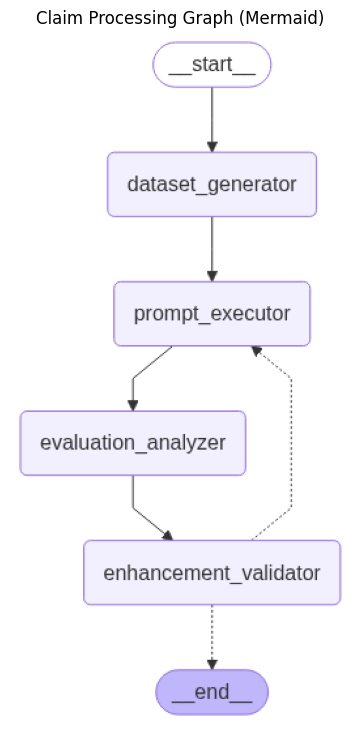

Graph displayed successfully.


In [26]:
import matplotlib.pyplot as plt
import io
from PIL import Image as PILImage
print("Attempting to generate and display graph using Mermaid + Matplotlib...")

try:
    # 1. Generate the Mermaid PNG data
    png_data = app.get_graph().draw_mermaid_png()

    # 2. Read the PNG data using PIL (Pillow)
    image = PILImage.open(io.BytesIO(png_data))

    # 3. Display using Matplotlib
    plt.figure(figsize=(12, 9)) # Optional: Adjust figure size
    plt.imshow(image)
    plt.axis('off')  # Hide axes for a cleaner look
    plt.title("Claim Processing Graph (Mermaid)") # Optional title
    plt.show()

    print("Graph displayed successfully.")
    # image.save("claim_graph_mermaid_mpl.png")

except ImportError as e:
    print(f"Error: {e}.")
    print("Ensure 'pyppeteer', 'matplotlib', and 'Pillow' are installed.")
    print("You might need to run 'python -m pyppeteer_install'.")
except Exception as e:
     print(f"An unexpected error occurred during Mermaid + Matplotlib visualization: {e}")
   